In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Step-2
# Find the Gaussian pyramid of the two images and the mask
def gaussian_pyramid(img, num_levels):
    lower = img.copy()
    gaussian_pyr = [lower]
    for i in range(num_levels):
        lower = cv2.pyrDown(lower)
        gaussian_pyr.append(np.float32(lower))
    return gaussian_pyr

# Step-3
# Then calculate the Laplacian pyramid
def laplacian_pyramid(gaussian_pyr):
    laplacian_top = gaussian_pyr[-1]
    num_levels = len(gaussian_pyr) - 1
    
    laplacian_pyr = [laplacian_top]
    for i in range(num_levels,0,-1):
        size = (gaussian_pyr[i - 1].shape[1], gaussian_pyr[i - 1].shape[0])
        gaussian_expanded = cv2.pyrUp(gaussian_pyr[i], dstsize=size)
        laplacian = np.subtract(gaussian_pyr[i-1], gaussian_expanded)
        laplacian_pyr.append(laplacian)
    return laplacian_pyr

# Step-4
# Now blend the two images wrt. the mask
def blend(laplacian_A,laplacian_B,mask_pyr):
    LS = []
    for la,lb,mask in zip(laplacian_A,laplacian_B,mask_pyr):
        ls = lb * mask + la * (1.0 - mask)
        LS.append(ls)
    return LS

# Step-5
# Reconstruct the original image
def reconstruct(laplacian_pyr):
    laplacian_top = laplacian_pyr[0]
    laplacian_lst = [laplacian_top]
    num_levels = len(laplacian_pyr) - 1
    for i in range(num_levels):
        size = (laplacian_pyr[i + 1].shape[1], laplacian_pyr[i + 1].shape[0])
        laplacian_expanded = cv2.pyrUp(laplacian_top, dstsize=size)
        laplacian_top = cv2.add(laplacian_pyr[i+1], laplacian_expanded)
        laplacian_lst.append(laplacian_top)
    return laplacian_lst



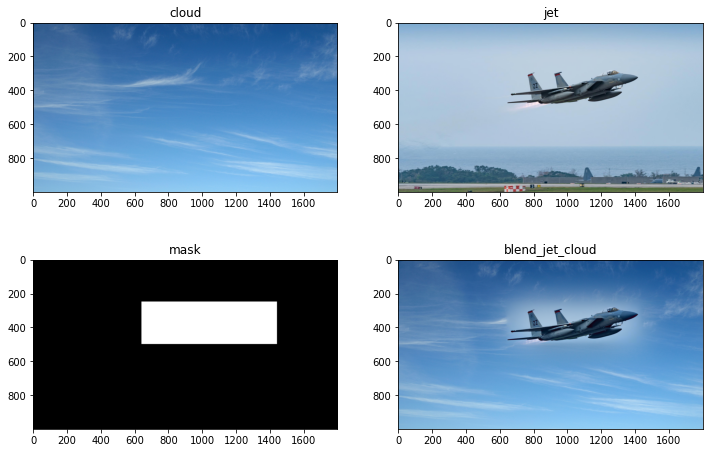

In [2]:
# Now let's call all these functions
if __name__ == '__main__':
    # Step-1
    # Load the two images
    img1 = cv2.imread('cloud.jpg')
    img1 = cv2.resize(img1, (1800, 1000))
    img2 = cv2.imread('jet.jpg')
    img2 = cv2.resize(img2, (1800, 1000))

    # Create the mask
    mask = np.zeros((1000,1800,3), dtype='float32')
    mask[250:500,640:1440,:] = (1,1,1)

    num_levels = 7

    # For image-1, calculate Gaussian and Laplacian
    gaussian_pyr_1 = gaussian_pyramid(img1, num_levels)
    laplacian_pyr_1 = laplacian_pyramid(gaussian_pyr_1)
    # For image-2, calculate Gaussian and Laplacian
    gaussian_pyr_2 = gaussian_pyramid(img2, num_levels)
    laplacian_pyr_2 = laplacian_pyramid(gaussian_pyr_2)
    # Calculate the Gaussian pyramid for the mask image and reverse it.
    mask_pyr_final = gaussian_pyramid(mask, num_levels)
    mask_pyr_final.reverse()
    # Blend the images
    add_laplace = blend(laplacian_pyr_1,laplacian_pyr_2,mask_pyr_final)
    # Reconstruct the images
    final  = reconstruct(add_laplace)
    # Save the final image to the disk
    cv2.imwrite('blend_jet_cloud.jpg',final[num_levels])

    # Show the images
    blend_result = final[num_levels].copy()
    blend_result = np.absolute(blend_result)
    blend_result = np.uint8(blend_result)

    img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
    plt.subplot(2,2,1)
    plt.title('cloud')
    plt.imshow(img1)

    img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
    plt.subplot(2,2,2)
    plt.title('jet')
    plt.imshow(img2)

    plt.subplot(2,2,3)
    plt.title('mask')
    plt.imshow(mask)

    blend_result = cv2.cvtColor(blend_result, cv2.COLOR_BGR2RGB)
    plt.subplot(2,2,4)
    plt.title('blend_jet_cloud')
    plt.imshow(blend_result)

    plt.gcf().set_size_inches(12, 8)
    plt.show()